# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [43]:
#!pip install palmerpenguins
from palmerpenguins import load_penguins
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from plotnine import *

In [7]:
penguins = load_penguins()
penguins = penguins.dropna()
penguins.head(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [8]:
def species_classifier(modeltype, score, *args, **argsnum):
    X = penguins.drop('species', axis=1)
    y = penguins['species']

    ct = ColumnTransformer([
        ('dummify', OneHotEncoder(handle_unknown='ignore'),
        make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough")

    model_pipeline = Pipeline([
        ("preprocessing", ct),
        ("model", modeltype(*args, **argsnum))
    ])

    model_pipeline.fit(X, y)
    accuracy = cross_val_score(model_pipeline, X, y, cv=5, scoring=score).mean()
    return accuracy

In [40]:
def adelie_roc_cm(modeltype, *args, **argsnum):
  species_dummies = pd.get_dummies(penguins['species'])

  X = penguins.drop('species', axis=1)
  y = species_dummies['Adelie']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  ct = ColumnTransformer([
        ('dummify', OneHotEncoder(handle_unknown='ignore'),
        make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough")

  model_pipeline = Pipeline([
        ("preprocessing", ct),
        ("model", modeltype(*args, **argsnum))
    ])

  fitted = model_pipeline.fit(X_train, y_train)

  y_preds = fitted.predict_proba(X_test)[:,1]

  false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_preds)
  roc_data = pd.DataFrame({
        'False Positive Rate': false_positive_rate1,
        'True Positive Rate': true_positive_rate1})


  roc_plot = (
    ggplot(roc_data, aes(x='False Positive Rate', y='True Positive Rate')) +
    geom_line() +
    labs(title='ROC Curve', x='False Positive Rate', y='True Positive Rate')
  )
  y_pred_class = (y_preds > 0.5).astype(int)

  cm = confusion_matrix(y_test, y_pred_class)
  return roc_plot, cm

Two knn models - accuracy

In [9]:
species_classifier(KNeighborsClassifier, n_neighbors = 5, score = 'accuracy'), species_classifier(KNeighborsClassifier, n_neighbors = 10, score = 'accuracy')

(0.9939846223428311, 0.9909995477159657)

Two knn models - recall

In [10]:
species_classifier(KNeighborsClassifier, n_neighbors = 5, score = 'recall_weighted'), species_classifier(KNeighborsClassifier, n_neighbors = 10, score = 'recall_weighted')

(0.9939846223428311, 0.9909995477159657)

Two knn models - precision

In [11]:
species_classifier(KNeighborsClassifier, n_neighbors = 5, score = 'precision_weighted'), species_classifier(KNeighborsClassifier, n_neighbors = 10, score = 'precision_weighted')

(0.9944000775344058, 0.9913990652796623)

Two knn models - f1

In [12]:
species_classifier(KNeighborsClassifier, n_neighbors = 5, score = 'f1_weighted'), species_classifier(KNeighborsClassifier, n_neighbors = 10, score = 'f1_weighted')

(0.9940394393988493, 0.9909599222111221)

Two knn models - ROC AUC

In [13]:
species_classifier(KNeighborsClassifier, n_neighbors = 5, score = 'roc_auc_ovr'), species_classifier(KNeighborsClassifier, n_neighbors = 10, score = 'roc_auc_ovr')

(0.9998496566725859, 0.9999248283362929)

Decision tree - accuracy

In [14]:
species_classifier(DecisionTreeClassifier, max_depth = 5, min_samples_leaf = 1, score = 'accuracy'), species_classifier(DecisionTreeClassifier, max_depth = 5, min_samples_leaf = 5, score = 'accuracy')

(0.9728177295341475, 0.9489823609226594)

Decision tree - recall

In [15]:
species_classifier(DecisionTreeClassifier, max_depth = 5, min_samples_leaf = 1, score = 'recall_weighted'), species_classifier(DecisionTreeClassifier, max_depth = 5, min_samples_leaf = 5, score = 'recall_weighted')

(0.9758480325644505, 0.9489823609226594)

Decision tree - precision

In [16]:
species_classifier(DecisionTreeClassifier, max_depth = 5, min_samples_leaf = 1, score = 'precision_weighted'), species_classifier(DecisionTreeClassifier, max_depth = 5, min_samples_leaf = 5, score = 'precision_weighted')

(0.9854538993344963, 0.9506503406720064)

Decision tree - f1

In [17]:
species_classifier(DecisionTreeClassifier, max_depth = 5, min_samples_leaf = 1, score = 'f1_weighted'), species_classifier(DecisionTreeClassifier, max_depth = 5, min_samples_leaf = 5, score = 'f1_weighted')

(0.9788430770305295, 0.9484992666814185)

Decision tree - ROC AUC

In [18]:
species_classifier(DecisionTreeClassifier, max_depth = 5, min_samples_leaf = 1, score = 'roc_auc_ovr'), species_classifier(DecisionTreeClassifier, max_depth = 5, min_samples_leaf = 5, score = 'roc_auc_ovr')

(0.9838736369619326, 0.9838388263463249)

ROC AUC graph for knn and confucion matrix

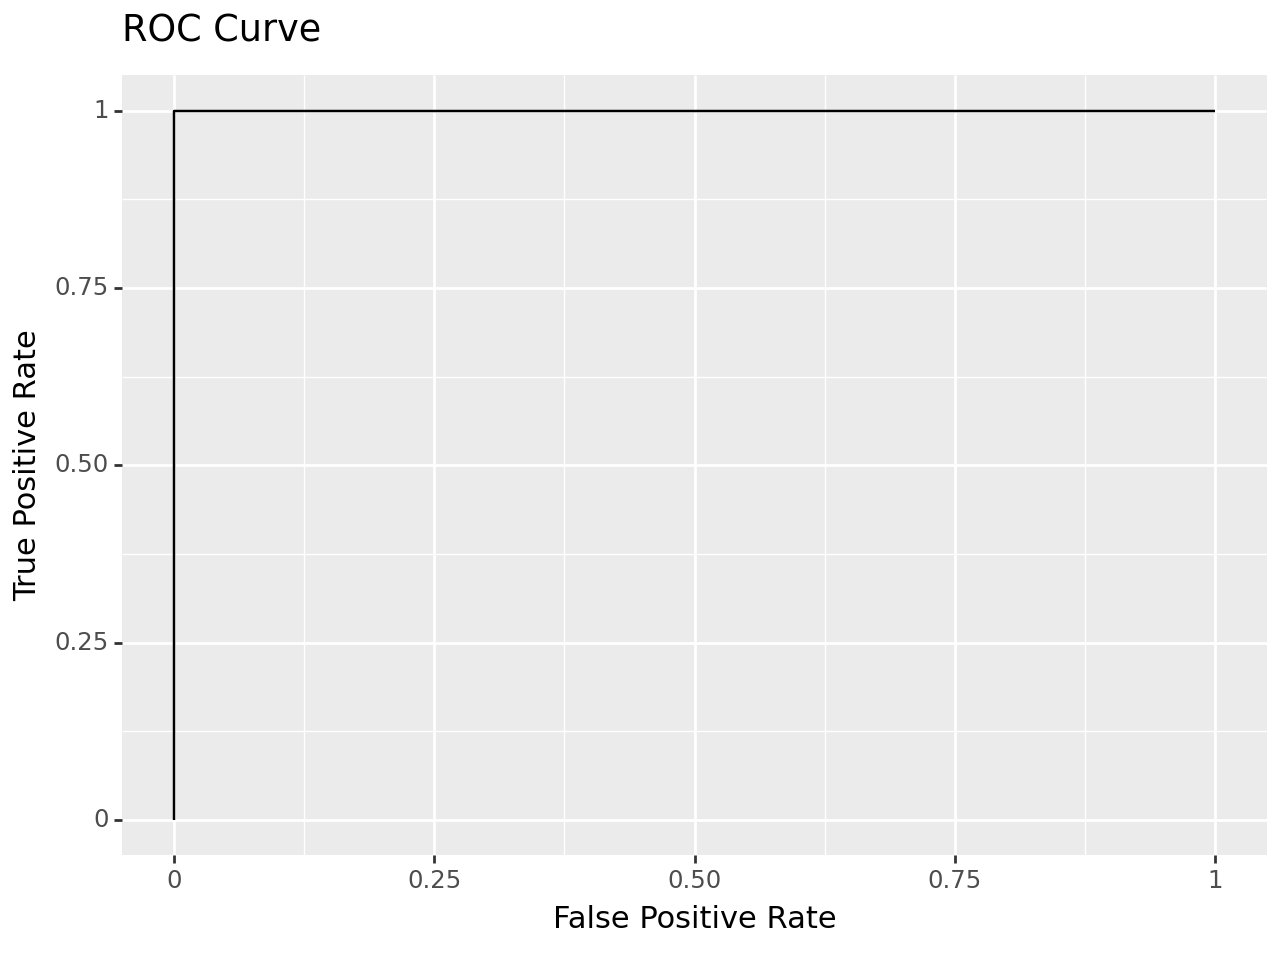

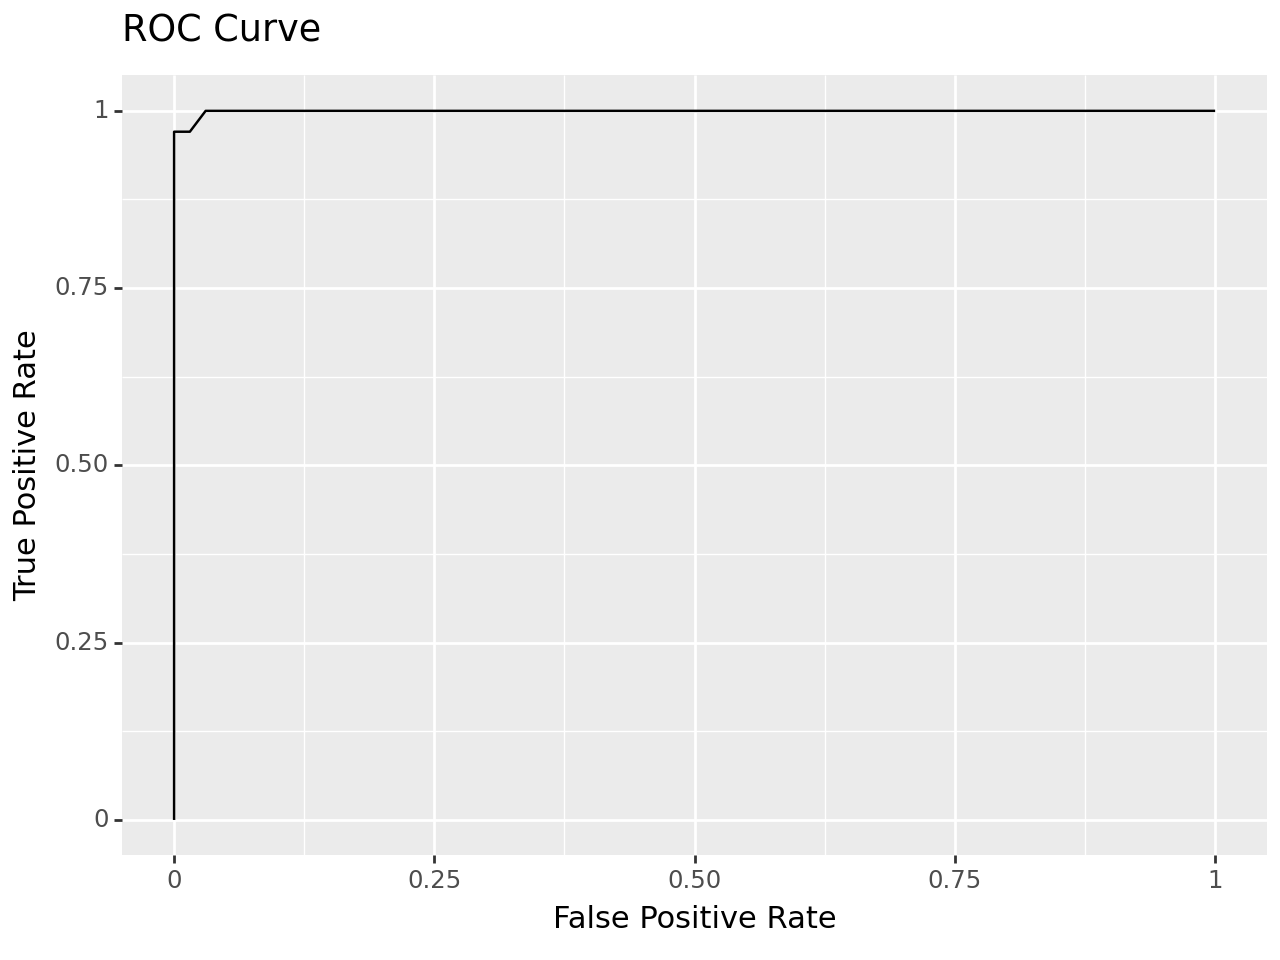

((<Figure Size: (640 x 480)>,
  array([[59,  0],
         [ 0, 41]])),
 (<Figure Size: (640 x 480)>,
  array([[65,  1],
         [ 1, 33]])))

In [42]:
adelie_roc_cm(KNeighborsClassifier, n_neighbors=5), adelie_roc_cm(KNeighborsClassifier, n_neighbors=10)

ROC AUC graph for decision tree and confucion matrix

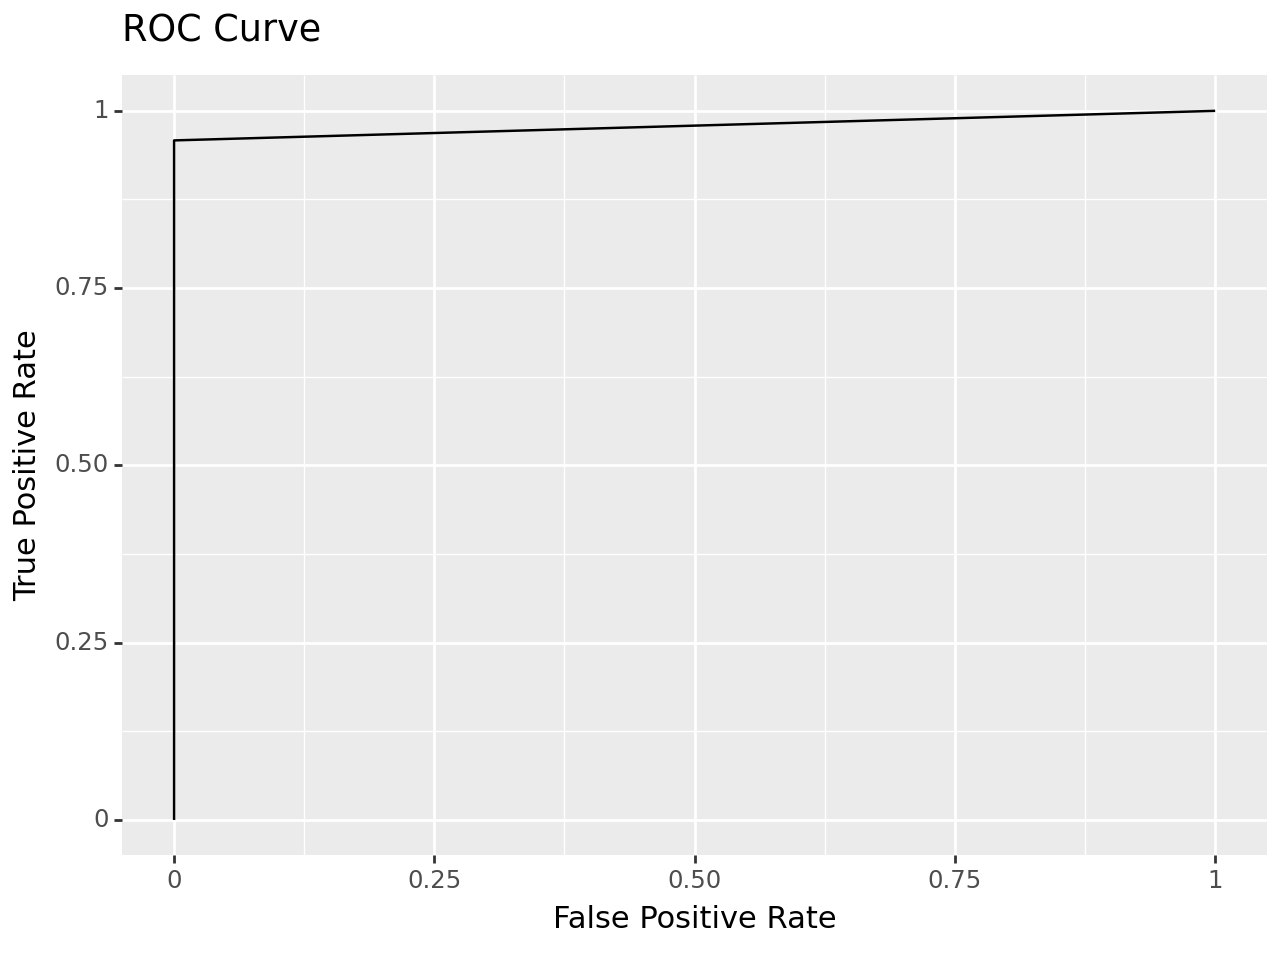

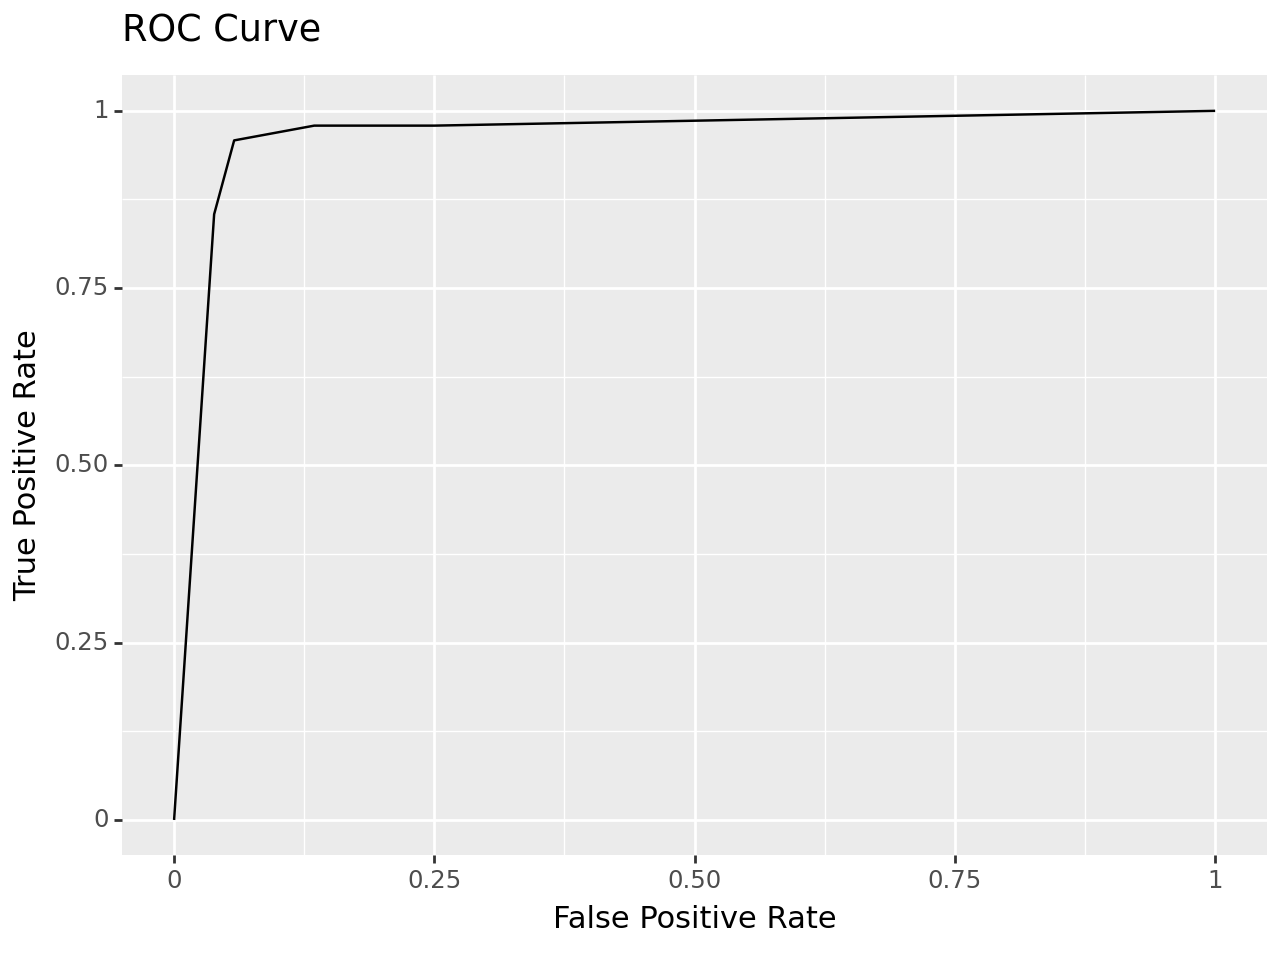

((<Figure Size: (640 x 480)>,
  array([[52,  0],
         [ 2, 46]])),
 (<Figure Size: (640 x 480)>,
  array([[49,  3],
         [ 2, 46]])))

In [44]:
adelie_roc_cm(DecisionTreeClassifier, max_depth = 5, min_samples_leaf = 1), adelie_roc_cm(DecisionTreeClassifier, max_depth = 5, min_samples_leaf = 5)